The first model we built is XGBoost, using the label encoded categorical variables along with our continuous variables as the input. Our baseline log loss was `0.55` and our baseline accuracy was `76%` using the default hyperparameters for XGBoost.

The hyperparameters we tuned can be defined as follows:

> `colsample_bytree` is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.

> `eta` Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.

> `eval_metric` is the way we will evaluate our best set of parameters, in this case `logloss`

> `max_depth` is the maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.

> `min_child_weight` is the minimum sum of instance weight needed in a child. A larger weight will result in a more conservative algorithm.

> `objective` is the type of algorithm

> `subsample` is the subsample ratio of the training instances. A value of 0.5 means half the data would be randomly sampled.

We used a grid search to tune our hyperparameters, and got the following as our results:

|Hyperparameter|Value|
| --- | --- |
|'colsample_bytree'|1.0|
 |'eta'|0.01|
 |'eval_metric'|'logloss'|
 |'max_depth'|9|
| 'min_child_weight'|5|
 |'objective'|'binary:logistic'|
 |'subsample'|1.0|
 
While the `eta` value of `0.005` was slightly lower log loss, it took twice as long to run as `eta` of `.01` so we opted to sacrifice that small log loss for a faster run time.

Our tuned model reduced log loss to `0.47` while increasing accuracy to `77%`.

The second model we built is RandomForest, using the label encoded categorical variables along with our continuous variables as the input. Our baseline log loss was `7.61` and our baseline accuracy was `78%` using the default hyperparameters for RandomForest.

We were not able to produce tuning with the full complement of all features in the data set within a reasonable run time, so we decided to reduce the number of features. We found that 37 features accounted for >99% of all variance in our initial model, so we used those 37 features for parameter tuning. This process was accomplished via `sklearn`'s `SelectFromModel` function.

The hyperparameters we tuned can be described as follows:

>`bootstrap` is a statistical resampling technique involving random sampling. Can be true or false.

>`max_depth` is the maximum number of levels in each decision tree.

>`max_features` is the maximum number of features Random Forest is allowed to try in individual tree.

>`min_samples_leaf` is the minimum number of leaf nodes you can have.

>`min_samples_split` is the minimum number of samples placed in a node before the node is aplit.

>`n_estimators` is the number of trees you want to build before taking the maximum voting or averages of predictions. Higher number of trees give you better performance but makes your code slower.

We used both a grid search and a random search to tune hyperparameters, and got the following as our results:

|Hyperparameter|Value|
| --- | --- |
|'bootstrap'|True|
 |'max_depth'|80|
 |'max_features'|3|
 |'min_samples_leaf'|4|
 |'min_samples_split'|10|
 |'n_estimators'|1000|
 
Our tuned model reduced log loss to `7.35` while increasing accuracy to `79%`.

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("C://Users//WilliamNayden//Documents//MSDS//case_8.csv", index_col=0)
target = df['target']
df.drop(['target'],inplace=True, axis=1)

In [3]:
objList = df.select_dtypes(include = "object").columns
print (objList)

#Label Encoding for object to numeric conversion
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in objList:
    df[feat] = le.fit_transform(df[feat].astype(str))

print (df.info())

Index(['v3', 'v22', 'v24', 'v30', 'v31', 'v47', 'v52', 'v56', 'v66', 'v71',
       'v74', 'v75', 'v79', 'v91', 'v107', 'v110', 'v112', 'v113', 'v125'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 114321 entries, 3 to 228713
Columns: 131 entries, v1 to v131
dtypes: float64(108), int32(19), int64(4)
memory usage: 106.8 MB
None


In [5]:
train = df
print(train)

              v1        v2  v3        v4         v5        v6        v7  \
ID                                                                        
3       1.335739  8.727474   2  3.921026   7.915266  2.599278  3.176895   
4       1.630686  7.464411   2  4.145098   9.191265  2.436402  2.483921   
5       0.943877  5.310079   2  4.410969   5.326159  3.979592  3.928571   
6       0.797415  8.304757   2  4.225930  11.627438  2.097700  1.987549   
8       1.630686  7.464411   2  4.145098   8.742359  2.436402  2.483921   
...          ...       ...  ..       ...        ...       ...       ...   
228708  1.630686  7.464411   2  4.145098   8.742359  2.436402  2.483921   
228710  1.630686  7.464411   2  4.145098   8.742359  2.436402  2.483921   
228711  1.630686  7.464411   2  4.145098  10.069277  2.436402  2.483921   
228712  1.630686  7.464411   2  4.145098  10.106144  2.436402  2.483921   
228713  1.619763  7.932978   2  4.640085   8.473141  2.351470  2.826766   

              v8        

In [6]:
print("Dataset has {} entries and {} features".format(*train.shape))

Dataset has 114321 entries and 131 features


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.33, random_state=42)

In [7]:
xgtrain = xgb.DMatrix(X_train.values, y_train.values)
xgtest = xgb.DMatrix(X_test.values, y_test.values)

In [8]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [9]:
from sklearn.metrics import log_loss, accuracy_score

In [17]:
import numpy as np
# "Learn" the mean from the training data
mean_train = np.mean(y_train)
# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train

# Compute Log Loss and Accuracy
log_baseline = log_loss(y_test, baseline_predictions)
acc_baseline = accuracy_score(y_test, np.ones(baseline_predictions.shape))

print("Baseline Accuracy is {:.2f}".format(acc_baseline))
print("Baseline Log Loss is {:.2f}".format(log_baseline))

Baseline Accuracy is 0.76
Baseline Log Loss is 0.55


In [18]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}

In [19]:
params['eval_metric'] = "logloss"

In [20]:
num_boost_round = 999

In [21]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-logloss:0.59585
[1]	Test-logloss:0.54349
[2]	Test-logloss:0.51408
[3]	Test-logloss:0.49622
[4]	Test-logloss:0.48699
[5]	Test-logloss:0.48083
[6]	Test-logloss:0.47772
[7]	Test-logloss:0.47577
[8]	Test-logloss:0.47423
[9]	Test-logloss:0.47283
[10]	Test-logloss:0.47257
[11]	Test-logloss:0.47378
[12]	Test-logloss:0.47440
[13]	Test-logloss:0.47358
[14]	Test-logloss:0.47444
[15]	Test-logloss:0.47440
[16]	Test-logloss:0.47383
[17]	Test-logloss:0.47389
[18]	Test-logloss:0.47399
[19]	Test-logloss:0.47445
[20]	Test-logloss:0.47463


In [22]:
print("Best Log Loss: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

Best Log Loss: 0.47 with 11 rounds


In [23]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'logloss','error'},
    early_stopping_rounds=10
)
cv_results

,train-logloss-mean,train-logloss-std,train-error-mean,train-error-std,test-logloss-mean,test-logloss-std,test-error-mean,test-error-std
0,0.594222,0.000169,0.219355,0.000534,0.596227,0.000418,0.224218,0.002851
1,0.540254,0.000323,0.217635,0.000961,0.543916,0.000762,0.222469,0.002365
2,0.509214,0.000319,0.217090,0.000899,0.514469,0.001079,0.221777,0.003009
3,0.490312,0.000534,0.216398,0.000668,0.497500,0.001061,0.221385,0.002789
4,0.478276,0.000566,0.215363,0.000992,0.487557,0.001440,0.221529,0.002131
5,0.470668,0.000516,0.214616,0.000748,0.482328,0.001366,0.221673,0.002325
6,0.465326,0.000499,0.213781,0.000831,0.479303,0.001508,0.221712,0.002283
7,0.461288,0.000448,0.212416,0.001194,0.477426,0.001778,0.221359,0.002064


In [24]:
print('Best Accuracy: {}', (1-cv_results['test-error-mean'].min()))
print('Best Log Loss: {}'cv_results['test-logloss-mean'].min())

0.47742579999999996

In [25]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [26]:
# Define initial best params and Log Loss
min_logloss = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'logloss', 'error'},
        early_stopping_rounds=10
    )
    # Update best Log Loss
    mean_logloss = cv_results['test-logloss-mean'].min()
    mean_error = cv_results['test-error-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\Log Loss {} for {} rounds".format(mean_logloss, boost_rounds))
    print("\Accuracy {} for {} rounds".format((1-mean_error), boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, Log Loss: {}, Accuracy: {}".format(best_params[0], best_params[1], min_logloss, (1-mean_error)))

CV with max_depth=9, min_child_weight=5
\Log Loss 0.48336480000000004 for 6 rounds
\Accuracy 0.7757031999999999 for 6 rounds
CV with max_depth=9, min_child_weight=6
\Log Loss 0.4841996 for 6 rounds
\Accuracy 0.7746982 for 6 rounds
CV with max_depth=9, min_child_weight=7
\Log Loss 0.48552100000000004 for 6 rounds
\Accuracy 0.775168 for 6 rounds
CV with max_depth=10, min_child_weight=5
\Log Loss 0.48895039999999995 for 6 rounds
\Accuracy 0.7722826 for 6 rounds
CV with max_depth=10, min_child_weight=6
\Log Loss 0.4901923999999999 for 5 rounds
\Accuracy 0.7731184 for 5 rounds
CV with max_depth=10, min_child_weight=7
\Log Loss 0.48927000000000004 for 5 rounds
\Accuracy 0.7733534 for 5 rounds
CV with max_depth=11, min_child_weight=5
\Log Loss 0.49479239999999997 for 5 rounds
\Accuracy 0.7702854 for 5 rounds
CV with max_depth=11, min_child_weight=6
\Log Loss 0.493811 for 5 rounds
\Accuracy 0.7701938 for 5 rounds
CV with max_depth=11, min_child_weight=7
\Log Loss 0.49371279999999995 for 5 roun

In [27]:
params['max_depth'] = 9
params['min_child_weight'] = 5

In [28]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [29]:
min_logloss = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'logloss', 'error'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_logloss = cv_results['test-logloss-mean'].min()
    mean_error = cv_results['test-error-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLog Loss {} for {} rounds".format(mean_logloss, boost_rounds))
    print("\tAccuracy {} for {} rounds".format((1-mean_error), boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = (subsample,colsample)
print("Best params: {}, {}, Log Loss: {}, Accuracy: {}".format(best_params[0], best_params[1], min_logloss, (1-mean_error)))

CV with subsample=1.0, colsample=1.0
	Log Loss 0.48336480000000004 for 6 rounds
	Accuracy 0.7757031999999999 for 6 rounds
CV with subsample=1.0, colsample=0.9
	Log Loss 0.48473760000000005 for 7 rounds
	Accuracy 0.7745544 for 7 rounds
CV with subsample=1.0, colsample=0.8
	Log Loss 0.48653880000000005 for 7 rounds
	Accuracy 0.774228 for 7 rounds
CV with subsample=1.0, colsample=0.7
	Log Loss 0.48524400000000006 for 6 rounds
	Accuracy 0.7760036 for 6 rounds
CV with subsample=0.9, colsample=1.0
	Log Loss 0.486137 for 6 rounds
	Accuracy 0.7745936 for 6 rounds
CV with subsample=0.9, colsample=0.9
	Log Loss 0.48725879999999994 for 6 rounds
	Accuracy 0.7741366000000001 for 6 rounds
CV with subsample=0.9, colsample=0.8
	Log Loss 0.4877432 for 6 rounds
	Accuracy 0.774437 for 6 rounds
CV with subsample=0.9, colsample=0.7
	Log Loss 0.4893510000000001 for 5 rounds
	Accuracy 0.7747499999999999 for 5 rounds
CV with subsample=0.8, colsample=1.0
	Log Loss 0.49988839999999996 for 3 rounds
	Accuracy 0.7

In [30]:
params['subsample'] = 1.0
params['colsample_bytree'] = 1.0

In [32]:
%time

# This can take some time…
min_logloss = float("Inf")
best_params = None

for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    
    # We update our parameters
    params['eta'] = eta
    
    # Run and time CV
    %time cv_results = xgb.cv(params,dtrain,num_boost_round=num_boost_round,seed=42,nfold=5,metrics=['logloss', 'error'],early_stopping_rounds=10)
    
    # Update best score
    mean_logloss = cv_results['test-logloss-mean'].min()
    mean_error = cv_results['test-error-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLog Loss {} for {} rounds\n".format(mean_logloss, boost_rounds))
    print("\tAccuracy {} for {} rounds".format((1-mean_error), boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = eta
print("Best params: {}, Log Loss: {}, Accuracy: {}".format(best_params, min_logloss, (1-mean_error)))

Wall time: 0 ns
CV with eta=0.3
Wall time: 34.7 s
	Log Loss 0.48336480000000004 for 6 rounds

	Accuracy 0.7757031999999999 for 6 rounds
CV with eta=0.2
Wall time: 1min 7s
	Log Loss 0.4802938 for 11 rounds

	Accuracy 0.777009 for 11 rounds
CV with eta=0.1
Wall time: 2min 11s
	Log Loss 0.4761602 for 32 rounds

	Accuracy 0.7786150000000001 for 32 rounds
CV with eta=0.05
Wall time: 2min 27s
	Log Loss 0.4761278000000001 for 51 rounds

	Accuracy 0.7786801999999999 for 51 rounds
CV with eta=0.01
Wall time: 3min 43s
	Log Loss 0.5274683999999998 for 85 rounds

	Accuracy 0.7775574 for 85 rounds
CV with eta=0.005
Wall time: 3min 38s
	Log Loss 0.582802 for 83 rounds

	Accuracy 0.7761342 for 83 rounds
Best params: 0.05, Log Loss: 0.4761278000000001, Accuracy: 0.7761342


In [33]:
#Significantly reduces runtime
params['eta'] = .01

In [34]:
params
{'colsample_bytree': 1.0,
 'eta': 0.01,
 'eval_metric': 'logloss',
 'max_depth': 9,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'subsample': 1.0}

{'colsample_bytree': 1.0,
 'eta': 0.01,
 'eval_metric': 'logloss',
 'max_depth': 9,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'subsample': 1.0}

In [35]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'logloss','error'},
    early_stopping_rounds=10
)

print("Best Log Loss: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))
print("Best Accuracy: {:.2f}".format(1-cv_results['test-error-mean'].min()))


[0]	Test-logloss:0.68934
[1]	Test-logloss:0.68560
[2]	Test-logloss:0.68194
[3]	Test-logloss:0.67836
[4]	Test-logloss:0.67484
[5]	Test-logloss:0.67139
[6]	Test-logloss:0.66799
[7]	Test-logloss:0.66467
[8]	Test-logloss:0.66141
[9]	Test-logloss:0.65821
[10]	Test-logloss:0.65507
[11]	Test-logloss:0.65200
[12]	Test-logloss:0.64899
[13]	Test-logloss:0.64603
[14]	Test-logloss:0.64313
[15]	Test-logloss:0.64030
[16]	Test-logloss:0.63749
[17]	Test-logloss:0.63475
[18]	Test-logloss:0.63205
[19]	Test-logloss:0.62942
[20]	Test-logloss:0.62681
[21]	Test-logloss:0.62426
[22]	Test-logloss:0.62176
[23]	Test-logloss:0.61930
[24]	Test-logloss:0.61689
[25]	Test-logloss:0.61453
[26]	Test-logloss:0.61219
[27]	Test-logloss:0.60991
[28]	Test-logloss:0.60767
[29]	Test-logloss:0.60545
[30]	Test-logloss:0.60328
[31]	Test-logloss:0.60116
[32]	Test-logloss:0.59905
[33]	Test-logloss:0.59700
[34]	Test-logloss:0.59496
[35]	Test-logloss:0.59300
[36]	Test-logloss:0.59105
[37]	Test-logloss:0.58912
[38]	Test-logloss:0.58

[308]	Test-logloss:0.47097
[309]	Test-logloss:0.47094
[310]	Test-logloss:0.47091
[311]	Test-logloss:0.47087
[312]	Test-logloss:0.47085
[313]	Test-logloss:0.47082
[314]	Test-logloss:0.47078
[315]	Test-logloss:0.47076
[316]	Test-logloss:0.47072
[317]	Test-logloss:0.47069
[318]	Test-logloss:0.47065
[319]	Test-logloss:0.47063
[320]	Test-logloss:0.47059
[321]	Test-logloss:0.47057
[322]	Test-logloss:0.47054
[323]	Test-logloss:0.47051
[324]	Test-logloss:0.47048
[325]	Test-logloss:0.47044
[326]	Test-logloss:0.47043
[327]	Test-logloss:0.47037
[328]	Test-logloss:0.47032
[329]	Test-logloss:0.47030
[330]	Test-logloss:0.47026
[331]	Test-logloss:0.47023
[332]	Test-logloss:0.47017
[333]	Test-logloss:0.47015
[334]	Test-logloss:0.47013
[335]	Test-logloss:0.47009
[336]	Test-logloss:0.47006
[337]	Test-logloss:0.47004
[338]	Test-logloss:0.47003
[339]	Test-logloss:0.46998
[340]	Test-logloss:0.46993
[341]	Test-logloss:0.46991
[342]	Test-logloss:0.46988
[343]	Test-logloss:0.46983
[344]	Test-logloss:0.46982
[

In [60]:
d1 = model.get_score(importance_type='gain')
l1 = list(d1.items())

In [66]:
# List of tuples with variable and importance
feature_importances = list(model.get_score(importance_type='weight').items())

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: v50                  Importance: 8038
Variable: v21                  Importance: 3342
Variable: v22                  Importance: 3336
Variable: v34                  Importance: 3138
Variable: v10                  Importance: 3103
Variable: v14                  Importance: 2767
Variable: v12                  Importance: 2719
Variable: v40                  Importance: 2701
Variable: v66                  Importance: 2432
Variable: v125                 Importance: 2107
Variable: v56                  Importance: 2068
Variable: v114                 Importance: 1818
Variable: v113                 Importance: 1532
Variable: v24                  Importance: 1498
Variable: v47                  Importance: 1456
Variable: v52                  Importance: 1416
Variable: v23                  Importance: 1416
Variable: v6                   Importance: 1386
Variable: v99                  Importance: 1318
Variable: v112                 Importance: 1285
Variable: v88                  Importanc

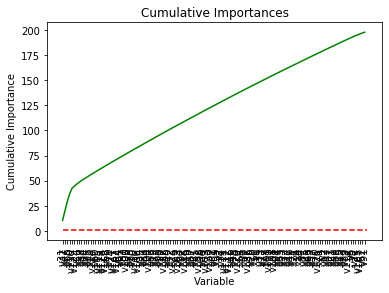

In [65]:
import matplotlib.pyplot as plt

# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# list of x locations for plotting
x_values = list(range(len(feature_importances)))

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [75]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(((sum(range(sorted_importances))/cumulative_importances) > 0.95)[0][0] + 1)

SyntaxError: unexpected EOF while parsing (<ipython-input-75-29cddb0ced68>, line 3)

In [8]:
# Convert to numpy arrays
import numpy as np

original_features = np.array(train)
original_labels = np.array(target)

# Training and Testing Sets
from sklearn.model_selection import train_test_split

original_train_features, original_test_features, original_train_labels, original_test_labels = train_test_split(original_features, original_labels, 
                                                                            test_size = 0.33, random_state = 42)

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
feature_list = list(train.columns)

# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model 
rf = RandomForestClassifier()

# Train the model on training data
rf.fit(original_train_features, original_train_labels);

# Use the forest's predict method on the test data
predictions = rf.predict(original_test_features)

#Get Log Loss and Accuracy
score = log_loss(original_test_labels, predictions)
acc = accuracy_score(original_test_labels, predictions)
# Print out the mean absolute error (mae)
print('Average log loss:', round(np.mean(score), 2),'.')
print('Average accuracy:', round(np.mean(acc), 2),'.')

Average log loss: 7.61 .
Average accuracy: 0.78 .


In [11]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: v50                  Importance: 0.08
Variable: v12                  Importance: 0.04
Variable: v10                  Importance: 0.03
Variable: v14                  Importance: 0.03
Variable: v21                  Importance: 0.03
Variable: v22                  Importance: 0.03
Variable: v34                  Importance: 0.03
Variable: v40                  Importance: 0.03
Variable: v114                 Importance: 0.03
Variable: v52                  Importance: 0.02
Variable: v56                  Importance: 0.02
Variable: v66                  Importance: 0.02
Variable: v112                 Importance: 0.02
Variable: v125                 Importance: 0.02
Variable: v1                   Importance: 0.01
Variable: v5                   Importance: 0.01
Variable: v6                   Importance: 0.01
Variable: v24                  Importance: 0.01
Variable: v28                  Importance: 0.01
Variable: v31                  Importance: 0.01
Variable: v36                  Importanc

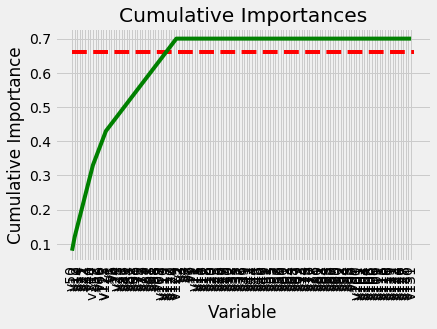

In [13]:
import matplotlib.pyplot as plt

# Reset style 
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.66, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [14]:
# Find number of features for cumulative importance of 66% (max importance)
# Add 1 because Python is zero-indexed
print('Number of features for max importance:', np.where(cumulative_importances > 0.66)[0][0] + 1)

Number of features for max importance: 37


In [11]:
from sklearn.feature_selection import SelectFromModel

# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.01
sfm = SelectFromModel(rf, threshold=0.01)

# Train the selector
sfm.fit(original_train_features, original_train_labels)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,

In [12]:
# Print the names of the most important features
feat_labels = list(train.columns)

for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

v10
v12
v14
v21
v22
v34
v40
v47
v50
v52
v56
v66
v79
v91
v107
v112
v113
v114
v125


In [13]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [14]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier()

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our  Model
print(accuracy_score(y_test, y_important_pred))
print(log_loss(y_test,y_important_pred))

0.7792503843503155
7.624571249925074


In [22]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [23]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_important_train, y_train);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 35.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 164.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 323.4min finished


In [24]:
rf_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [14]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a base model
rf = RandomForestClassifier(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

In [15]:
# Fit the grid search to the data
grid_search.fit(X_important_train, y_train);

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 40.6min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 113.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 196.3min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 272.8min finished


In [16]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 1000}

In [17]:
# Apply The Full Featured Classifier To The Test Data
y_important_pred = grid_search.predict(X_important_test)

# View The Accuracy Of Our  Model
print(accuracy_score(y_test, y_important_pred))
print(log_loss(y_test,y_important_pred))

0.7817420346710492
7.53851746548729
